In [10]:
#rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, foreign)
font_add_google("Poppins", "pop")
showtext_auto()

In [11]:
##Crear folders de almacenamiento
dir.create("microdatos", showWarnings = F)

In [12]:
url_base<-"https://www.inegi.org.mx/contenidos/programas/emat/microdatos/matrimonios_base_datos_"
fin<-"_dbf.zip"

years<-c("2010_2014","2015_2019", "2020", "2021", "2022", "2023")

In [13]:
# Función para descargar y descomprimir un archivo con timeout
download_and_unzip <- function(url, destination="microdatos") {
  tryCatch({
    # Descargar el archivo con timeout
    download.file(url, destfile = paste0(destination, "/", basename(url)), mode = "wb", timeout = 10000)

    # Descomprimir el archivo
    unzip(paste0(destination, "/", basename(url)), exdir = destination)

    # Eliminar el archivo comprimido después de descomprimirlo
    unlink(paste0(destination, "/", basename(url)))

    message(paste("Descarga y descompresión exitosas para", basename(url)))
  }, error = function(e) {
    warning(paste("Error al descargar o descomprimir", basename(url), ":", conditionMessage(e)))
  })
}

In [14]:
for (year in years) {
  url <- paste0(url_base, year, fin)
  download_and_unzip(url)
}

Descarga y descompresión exitosas para matrimonios_base_datos_2010_2014_dbf.zip

Descarga y descompresión exitosas para matrimonios_base_datos_2015_2019_dbf.zip

Descarga y descompresión exitosas para matrimonios_base_datos_2020_dbf.zip

Descarga y descompresión exitosas para matrimonios_base_datos_2021_dbf.zip

Descarga y descompresión exitosas para matrimonios_base_datos_2022_dbf.zip

Descarga y descompresión exitosas para matrimonios_base_datos_2023_dbf.zip



In [21]:
anios <- 2010:2023
lista_matrimonios <- list()
ruta_base <- "microdatos/"

for (anio in anios) {
  sufijo <- substr(as.character(anio), 3, 4)
  
  # Determinar carpeta según el año
  if (anio >= 2015 & anio <= 2019) {
    carpeta <- file.path(ruta_base, paste0("matrimonios_base_datos_", anio))
  } else if (anio <= 2014) {
    carpeta <- file.path(ruta_base, paste0("matrimonios_base_datos_", anio, "_dbf"))
  } else {
    carpeta <- ruta_base
  }
  
  # Buscar archivo DBF con sufijo de año
  ruta_archivo <- list.files(
    path = carpeta,
    pattern = paste0("MATRI.*", sufijo, "\\.dbf$"),
    full.names = TRUE,
    ignore.case = TRUE
  )
  
  # Leer si existe
  if (length(ruta_archivo) == 1) {
    message("Leyendo: ", ruta_archivo)
    df <- read.dbf(ruta_archivo, as.is = TRUE) %>%
      janitor::clean_names() %>%
      mutate(across(everything(), as.character))  # Homogeneizar tipos
    lista_matrimonios[[as.character(anio)]] <- df
  } else {
    warning("Archivo DBF no encontrado para ", anio)
  }
}

# Combinar todas las tablas
matrimonios_completo <- bind_rows(lista_matrimonios, .id = "anio")

Leyendo: microdatos//matrimonios_base_datos_2010_dbf/MATRI10.dbf

Leyendo: microdatos//matrimonios_base_datos_2011_dbf/MATRI11.dbf

Leyendo: microdatos//matrimonios_base_datos_2012_dbf/MATRI12.dbf

Leyendo: microdatos//matrimonios_base_datos_2013_dbf/MATRI13.dbf

Leyendo: microdatos//matrimonios_base_datos_2014_dbf/MATRI14.dbf

Leyendo: microdatos//matrimonios_base_datos_2015/MATRI15.dbf

Leyendo: microdatos//matrimonios_base_datos_2016/MATRI16.DBF

Leyendo: microdatos//matrimonios_base_datos_2017/MATRI17.DBF

Leyendo: microdatos//matrimonios_base_datos_2018/MATRI18.DBF

Leyendo: microdatos//matrimonios_base_datos_2019/MATRI19.DBF

Leyendo: microdatos/MATRI20.DBF

Leyendo: microdatos/MATRI21.DBF

Leyendo: microdatos/MATRI22.dbf

Leyendo: microdatos/matri23.dbf



In [22]:
head(matrimonios_completo)

,anio,ent_regis,mun_regis,loc_regis,tam_loc_re,dia_regis,mes_regis,anio_regis,regimen_ma,genero,⋯,entrh_con2,munrh_con2,locrh_con2,tlorh_con2,escol_con2,conactcon2,sitlabcon2,postracon2,tipo_con,dis_re_oax
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1...1,2010,01,001,0001,15,4,1,2010,1,1,⋯,01,001,0001,15,5,1,1,2,1,999
2...2,2010,01,001,0001,15,6,1,2010,2,1,⋯,01,005,0001,10,5,2,3,9,1,999
3...3,2010,01,001,0001,15,6,1,2010,2,1,⋯,01,001,0001,15,5,2,3,9,1,999
4...4,2010,01,001,0001,15,7,1,2010,1,1,⋯,01,001,0001,15,5,1,1,2,1,999
5...5,2010,01,001,0001,15,7,1,2010,2,1,⋯,01,001,0001,15,7,2,2,9,1,999
6...6,2010,01,001,0001,15,8,1,2010,1,1,⋯,01,001,0001,15,6,1,1,2,1,999


In [23]:
#Total de matrimonios por año
matrimonios_por_anio <- matrimonios_completo %>%
filter(ent_regis == "09") %>%  
    group_by(anio_regis) %>%
    summarise(total_matrimonios = n())

ms<-matrimonios_completo%>%
#Filtrar matrionios del mismo sexo
filter(genero=="2")%>%
filter(ent_regis == "09") %>%
group_by(anio_regis,genero)%>%
summarise(mismo_sexo=n())%>%
#Pegar el total de matrimonios
left_join(matrimonios_por_anio, by=c("anio_regis")) %>%
#Calcular el porcentaje de matrimonios del mismo sexo
mutate(porcentaje_mismo_sexo = round((mismo_sexo / total_matrimonios) * 100, 2))

ms

`summarise()` has grouped output by 'anio_regis'. You can override using the
`.groups` argument.


anio_regis,genero,mismo_sexo,total_matrimonios,porcentaje_mismo_sexo
<chr>,<chr>,<int>,<int>,<dbl>
2010,2,689,34444,2.00
2011,2,802,35086,2.29
2012,2,936,35536,2.63
2013,2,1185,37073,3.20
2014,2,1612,36664,4.40
2015,2,1434,33230,4.32
2016,2,1481,32515,4.55
2017,2,1462,30868,4.74
2018,2,1457,26521,5.49


`geom_smooth()` using formula = 'y ~ x'


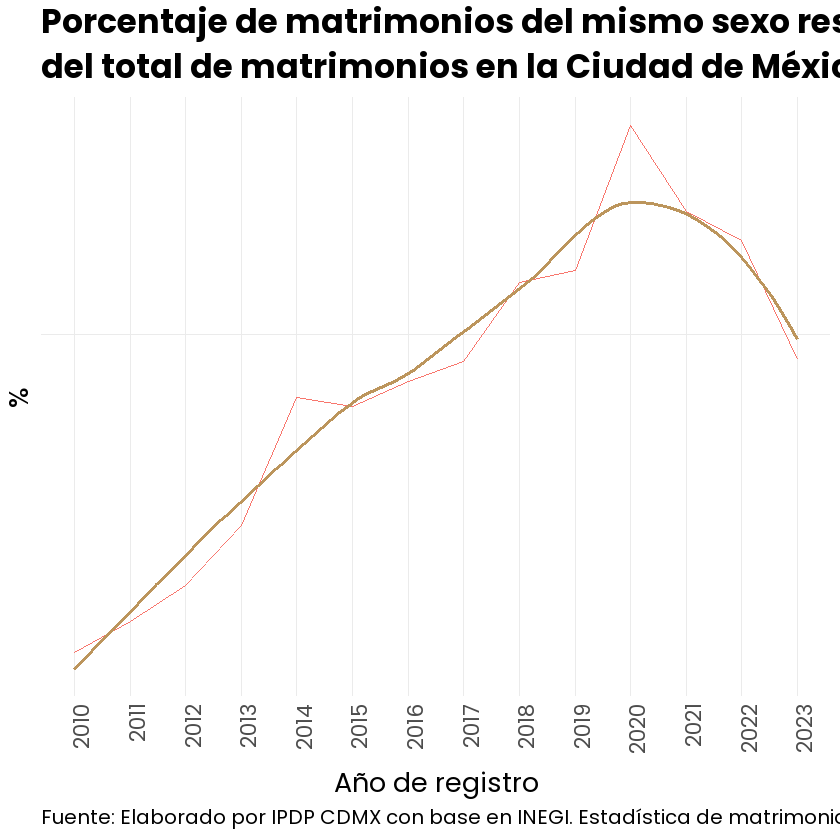

In [24]:
ms%>%
ggplot(aes(x=anio_regis, y=porcentaje_mismo_sexo,color = '#691c32', group=1)) +
geom_line()+
geom_smooth(method = 'loess', se = FALSE, color = '#bc955c') +
theme_minimal()+
labs(title="Porcentaje de matrimonios del mismo sexo respecto 
del total de matrimonios en la Ciudad de México,2010-2023",
     x="Año de registro",
     y="%",
      caption = "Fuente: Elaborado por IPDP CDMX con base en INEGI. Estadística de matrimonios 2010-2023."
     
     
     )+

scale_y_continuous(breaks = seq(0, 100, 10))+
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          plot.title = element_text(hjust = 0, size = 25, face = "bold"),
          plot.subtitle = element_text(hjust = 0, size = 20, face = "italic"),
          plot.caption = element_text(hjust = 0, size = 15),
          legend.position = "none",
          text = element_text(family = "pop", size = 20))